# XAUUSD

In [1]:
import quandl
import pandas as pd
import numpy as np

# plotting modules
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import os

import warnings
import logging

# scikit-learn modules
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.utils.validation import check_array


# User defined modules
from column_transformers.technical_indicators import MacdSignal, StochRsiSignal, StochasticRsi
from column_transformers.base import BaseStrategy
from column_transformers.dates import DateDummy

from itertools import product
from operator import itemgetter

In [2]:
xau_ratios = [
    "WGC/GOLD_DAILY_USD"
     #"WGC/GOLD_DAILY_EUR",
#     "WGC/GOLD_DAILY_TRY",
#     "WGC/GOLD_DAILY_JPY",
    #"WGC/GOLD_DAILY_GBP",
#     "WGC/GOLD_DAILY_CAD",
#     "WGC/GOLD_DAILY_CHF",
#     "WGC/GOLD_DAILY_VND",
#     "WGC/GOLD_DAILY_KRW",
#     "WGC/GOLD_DAILY_RUB",
#     "WGC/GOLD_DAILY_AUD",
]

economic_indc = []

### Quandl data terms

Anyone seeking to use this code must first apply for an account with [Quandl](https://www.quandl.com) in order to receive an valid authetitciation key.

In [3]:
DIR_NAME = os.path.abspath(os.path.join(os.getcwd(), '..'))
FILEPATH = os.path.join(DIR_NAME, "auth.txt")

with open(FILEPATH, "r") as f:
    authtoken = f.read();

# Retrieve Data

In [4]:
xau_df_dict = {}

for ratio in tqdm(xau_ratios):
    name = ratio.lower().replace("/", "_")

    # get the ratio dataframe
    df = quandl.get(ratio, authtoken=authtoken, start_date = "1979-01-01")
    df.columns = ["price"]
    
    # check for missing business days 
    if pd.infer_freq(df.index) != "B":
        logging.warn("Datetime frequency is not Business Days")
    
    xau_df_dict[name] = df

100%|██████████| 1/1 [00:03<00:00,  3.07s/it]


## Volatility

In [5]:
annualization_factor = 252.
window_size = [5, 10, 20, 60, 120]

for ratio, df in tqdm(xau_df_dict.items()):
    start_date, end_date = df.index[0], df.index[-1]
    full_range = pd.date_range(start_date, end_date, freq = "B")
    
    if not np.array_equal(df.index, pd.date_range(start_date, end_date, freq="B")):
        logging.warning("\n{} is missing business days".format(ratio))

    for window in window_size:
        df['{}d_market_vol'.format(window)] = np.sqrt(
            (annualization_factor/window) * df['price'].rolling(window).var(ddof=0))

100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


## Quandl Features

In [6]:
features = [
    "FRED/T10Y2Y",
    "RATEINF/INFLATION_USA",
]

In [7]:
for ratio, df in xau_df_dict.items():
    for feature in features:
        col_name = feature.lower().replace('/', '_')
        
        # get quandl features. `end_date` is set to df.index[-1] to match the price data
        data = quandl.get(feature, authtoken=authtoken, start_date = "1979-01-01", end_date = df.index[-1])
        start_date, end_date = data.index[0], data.index[-1]

        # Some features contain missing data. To best simulate how the data would be ingested
        # realtime, the current value is forward filled. This achieved by resampling.
        if not np.array_equal(data.index, pd.date_range(start_date, end_date, freq="B")):
            logging.warning("\n\t{} is missing business days".format(feature))
                    
        df[col_name] = data
    
    df[:] = df.ffill()

	FRED/T10Y2Y is missing business days
	RATEINF/INFLATION_USA is missing business days


## Technical indicator features

In [8]:
import talib

technical_indicators= {
#     "MACD" : ("macd", "macdsignal", "macdhist"),
#     "STOCHRSI" : ("fastk", "fastd"),
    "MOM" : ("real"),
    "APO" : ('real'),
    "RSI" : ('real')
}

for ratio, df in xau_df_dict.items():
    
    # talib requires market price data. starting price of $1 is taken
    # since absolute values are not important (preprocess scaling)
    price = df['price'].values

    for indicator, indicator_type in technical_indicators.items():
        # Return the result for each indicator
        if indicator == 'STOCHRSI':
            result = getattr(talib, indicator)(price, fastd_matype = 8)
        else:
            result = getattr(talib, indicator)(price)

        if isinstance(result, np.ndarray):
            df[indicator.lower()] = result
        else:
            for f, r in zip(indicator_type, result):
                if f == indicator.lower():
                    df["{}".format(indicator.lower())] = r
                else:
                    df["{}_{}".format(indicator.lower(), f)] = r

## Strategies

In [9]:
class StochasticRsiStrategy(BaseStrategy):
    
    # ======================================================================
    # Constants
    # ======================================================================
    
    """
    Define the indices of the price series and the to be insered indicators
    See Documentation for more information.
    """
    PRICE = 0 
    FASTK, FASTD = 12, 13
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs) 


    def _price_indicator(self, X, timeperiod, fastk, fastd):
        ind = StochasticRsi(self.PRICE, timeperiod, fastk, fastd)
        
        return ind.fit_transform(X)
        
    def _long_signal(self, price_indicator, long_entry, long_exit):
        
        # Use np.insert if shift is greater than 1
        signal_entry = price_indicator[:, self.FASTK] > long_entry
        signal_hold = price_indicator[:, self.FASTK] > long_exit
        
        # Define the long signal
        long = signal_entry | signal_hold
        
        return long[:-1] * 1
    
    
    def _short_signal(self, price_indicator, short_entry, short_exit):
        
        #Use np.insert if shift is greater than 1
        signal_entry = price_indicator[:, self.FASTK] < short_entry
        signal_hold = price_indicator[:, self.FASTK] <= short_exit
        
        # Define the long signal
        short = signal_entry | signal_hold
        
        return short[:-1] * -1    

    def x(self, X):
        X = check_array(X)
        return X[:, self.PRICE]


class MacdStrategy(BaseStrategy):
    
    # ======================================================================
    # Constants
    # ======================================================================
    
    """
    Define the indices of the price series and the to be insered indicators
    See Documentation for more information.
    """
    PRICE = 0 
    MACD, MACD_SIGNAL, MACD_HIST = 15, 16, 17
    
    # ======================================================================
    # Constructors
    # ======================================================================
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def _price_indicator(self, X, fast_period, slow_period, signal_period):
                
        real = X[:, self.PRICE]
        
        macd_statistics = talib.MACD(
            real,
            fastperiod = fast_period,
            slowperiod = slow_period,
            signalperiod = signal_period
        )   
        
        return np.c_[X, np.array(macd_statistics).T]
    
    def _long_signal(self, price_indicator):
        long = price_indicator[:,self.MACD] > price_indicator[:,self.MACD_SIGNAL]
        
        return long[:-1] * 1
    
    
    def _short_signal(self, price_indicator):
        short = price_indicator[:, self.MACD] < price_indicator[:, self.MACD_SIGNAL]
       
        return short[:-1] * -1

### Plotting function to complete

In [10]:
# longs = X_rsi.index[X_rsi['long'] == 1]
# shorts = X_rsi.index[X_rsi['short'] == -1]

# # start date positions of new long/short positions
# long_indices_or_sections = np.arange(longs.size)[longs.to_series().diff() > pd.Timedelta('3D')]
# short_indices_or_sections = np.arange(shorts.size)[shorts.to_series().diff() > pd.Timedelta('3D')]

# long_date_regions = np.split(longs, long_indices_or_sections)
# short_date_regions = np.split(shorts, short_indices_or_sections)

In [11]:
# sns.set(rc={'figure.figsize':(16, 10)})
# fig, axes = plt.subplots(nrows=3, ncols=1)

# df.loc['1990', 'alpha_perf'].plot(ax = axes[0])
# df.loc['1990', ['macd', 'macd_macdsignal']].plot(ax=axes[1])
# df.loc['1990', 'gold_perf'].plot(ax = axes[2])

# for l_period, s_period in zip(long_date_regions, short_date_regions):
#     for ax in axes:
#         ax.axvline(l_period[0], color='green', linewidth=1)
#         ax.axvline(s_period[0], color='green', linewidth=1)
                                             
#         ax.axvline(l_period[-1], color='red', linewidth=1)
#         ax.axvline(s_period[-1], color='red', linewidth=1)

#         ax.axvspan(l_period[0], l_period[-1], alpha = 0.1, color = 'green')
#         ax.axvspan(s_period[0], s_period[-1], alpha = 0.1, color = 'red')

## Data preprocessing 

In [19]:
from split._split import TrainValidateTest

data = xau_df_dict['wgc_gold_daily_usd'].copy()
# forward 5-day return
data['target'] = data['price'].shift(-5).pct_change(5)
    
    
# define training, validation and test data. The X and y data is split
# after the column transformation pipeline has been executed. This is to 
# ensure the the X and y observations are aligned.
tvt = TrainValidateTest(0.7, 0.15, 0.15)
train_data, valid_data, test_data = tvt.transform(data)
train_data.head(50)

,price,5d_market_vol,10d_market_vol,20d_market_vol,60d_market_vol,120d_market_vol,fred_t10y2y,rateinf_inflation_usa,mom,apo,rsi,target
Date,,,,,,,,,,,,
1979-01-01,226.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1979-01-02,226.80,NaN,NaN,NaN,NaN,NaN,-0.82,NaN,NaN,NaN,NaN,NaN
1979-01-03,218.60,NaN,NaN,NaN,NaN,NaN,-0.82,NaN,NaN,NaN,NaN,NaN
1979-01-04,223.15,NaN,NaN,NaN,NaN,NaN,-0.77,NaN,NaN,NaN,NaN,NaN
1979-01-05,225.50,21.053213,NaN,NaN,NaN,NaN,-0.77,NaN,NaN,NaN,NaN,NaN
1979-01-08,223.10,19.867376,NaN,NaN,NaN,NaN,-0.78,NaN,NaN,NaN,NaN,-0.028014
1979-01-09,224.00,16.361682,NaN,NaN,NaN,NaN,-0.76,NaN,NaN,NaN,NaN,-0.014955
1979-01-10,220.70,11.067618,NaN,NaN,NaN,NaN,-0.78,NaN,NaN,NaN,NaN,0.029678
1979-01-11,220.65,13.414476,NaN,NaN,NaN,NaN,-0.77,NaN,NaN,NaN,NaN,0.050306


In [22]:
stoch_params = dict(timeperiod = range(10,20, 2), fastk = range(2, 5), fastd = range(2, 5), ob_region = range(45, 60, 5), os_region = range(0, 15, 5))
macd_params = dict(fast_period = range(5, 10),slow_period = range(20, 40),signal_period = range(5, 25, 5))

preprocess_pipeline = Pipeline([
     ('stoch_ud_signal', StochasticRsiStrategy(**stoch_params)),
     ('macd_ud_signal', MacdStrategy(**macd_params)),
     #('date', DateDummy('weekday_name', 'month_name')),
     #('vol_diff', VolatilityDiff()),
     #('scalar', StandardScaler())
])

train_prepared, valid_prepared, test_prepared = (
    preprocess_pipeline.fit_transform(train_data),
    preprocess_pipeline.transform(valid_data),
    preprocess_pipeline.transform(test_data)
)



100%|██████████| 400/400 [00:00<00:00, 1209.77it/s]


In [25]:
train_prepared = train_prepared[~np.isnan(train_prepared).any(1), :]
valid_prepared = valid_prepared[~np.isnan(valid_prepared).any(1), :]

X_train = np.delete(train_prepared, [0, 11], axis=1)
X_valid = np.delete(valid_prepared, [0, 11], axis=1)

y_train = (train_prepared[:, 11] > 0).astype(int)
y_valid = (valid_prepared[:, 11] > 0).astype(int)

train_prepared[:, [0,15,16, 17]]

array([[ 2.80000000e+02,  8.88623879e+00,  9.33205986e+00,
        -4.45821062e-01],
       [ 2.78000000e+02,  8.31673934e+00,  9.20514479e+00,
        -8.88405454e-01],
       [ 2.80300000e+02,  8.07922610e+00,  9.06440495e+00,
        -9.85178858e-01],
       ...,
       [ 6.50500000e+02, -5.91181455e+00, -5.33374644e+00,
        -5.78068106e-01],
       [ 6.54750000e+02, -4.86376135e+00, -5.27499831e+00,
         4.11236956e-01],
       [ 6.54250000e+02, -4.08157330e+00, -5.12582018e+00,
         1.04424689e+00]])

## Model Selection

In [13]:
classifiers = [
    SVC(gamma=2, C=1),
    LogisticRegression(),
    RandomForestClassifier(criterion='entropy', oob_score=True, n_jobs=-1, random_state= 0),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GradientBoostingClassifier(n_estimators=100),
]

In [33]:
results = {}

for clf in tqdm(classifiers, unit='Model') :
    clf.fit(X_train, y_train)
    
    name = str(clf).split('(')[0]
    
    results[name] = {
        "train_score" : clf.score(X_train, y_train),  
        "valid_score" : clf.score(X_valid, y_valid)
    }      
    
results

 17%|█▋        | 1/6 [00:06<00:30,  6.04s/Model]/home/joepy/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/joepy/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/joepy/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/joepy/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
100%|██████████| 6/6 [00:09<00:00,  2.16s/Model]


{'SVC': {'train_score': 0.9158239956272205,
  'valid_score': 0.49677835051546393},
 'LogisticRegression': {'train_score': 0.5396283137469254,
  'valid_score': 0.5096649484536082},
 'RandomForestClassifier': {'train_score': 0.9793659469800492,
  'valid_score': 0.4993556701030928},
 'MLPClassifier': {'train_score': 0.5593058212626401,
  'valid_score': 0.529639175257732},
 'AdaBoostClassifier': {'train_score': 0.5765236403388904,
  'valid_score': 0.49291237113402064},
 'GradientBoostingClassifier': {'train_score': 0.6519540858157966,
  'valid_score': 0.5270618556701031}}

In [48]:
sns.set(rc={'figure.figsize':(16, 10)})
prob_array=[-1,1]
alpha_score = clf.predict_proba(X_train).dot(np.array(prob_array))
alpha_return = alpha_score * train_data.iloc[-alpha_score.size:, 11]

plt.plot((1 + alpha_return).cumprod())
plt.plot(train_data['price'] / train_data['price'][0])

clf.get_params

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

## Model Evaluation

In [56]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

tscv = TimeSeriesSplit(n_splits = 10)
clf =  RandomForestClassifier(criterion='entropy', oob_score=True, n_jobs=-1, random_state= 0)
rf_param_grid = {
    'max_depth': [25, 35],
    'min_samples_leaf': [5, 10],
    'min_samples_split': [2, 5],
    'n_estimators': [350, 400]
}

# search = GridSearchCV(estimator=clf, cv=tscv, param_grid=rf_param_grid)
# search.fit(X_train, y_train)

In [19]:
search.score(X_train, y_train), search.score(X_valid, y_valid), search.best_params_


(0.9307187756217545,
 0.5064432989690721,
 {'max_depth': 25,
  'min_samples_leaf': 10,
  'min_samples_split': 2,
  'n_estimators': 400})

In [57]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import precision_score, recall_score, precision_recall_curve

clf_parameters = {
    'n_estimators': 900 ,
    'criterion': 'entropy',
    'min_samples_leaf': 10,
    'max_depth' : 25,
    'min_samples_split': 2,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': 0}

clf =  RandomForestClassifier(**clf_parameters)

cross_val_score(clf, X_train, y_train, cv=tscv, scoring='accuracy')

array([0.53684211, 0.53383459, 0.50225564, 0.49323308, 0.4887218 ,
       0.44962406, 0.55488722, 0.55488722, 0.5037594 , 0.46165414])

In [ ]:
confusion_matrix(y_train, y_train_pred)

In [215]:
n_days = X_train.shape[0]
n_features = X_train.shape[1]

clf_parameters = {
    'criterion': 'entropy',
    'min_samples_leaf': 15,
    'max_depth' : 25,
     'min_samples_split': 8,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': 0}

n_trees_l = [5, 1000, 1500]

In [216]:
train_score = []
valid_score = []
oob_score = []
feature_importances = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    
    clf = RandomForestClassifier(**clf_parameters)
    clf.fit(X_train, y_train)
    
    train_score.append(clf.score(X_train, y_train))
    valid_score.append(clf.score(X_valid, y_valid))
    
    #oob_score.append(clf.oob_score_)
#     feature_importances.append(clf.feature_importances_)

Training Models:   0%|          | 0/3 [00:00<?, ?Model/s]/home/joepy/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/joepy/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/joepy/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/joepy/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
Training Models:  33%|███▎      | 1/3 [00:00<00:00,  2.32Model/s]/home/joepy

ValueError: x and y must have same first dimension, but have shapes (3,) and (0,)

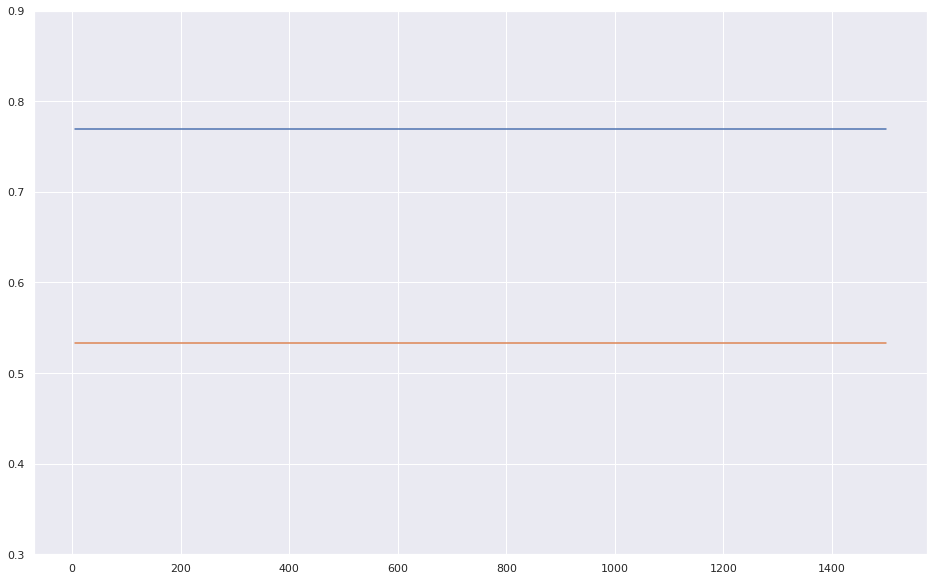

In [217]:
def plot(xs, ys, labels, title='', x_label='', y_label=''):
    for x, y, label in zip(xs, ys, labels):
        plt.ylim((0.3, 0.9))
        plt.plot(x, y, label=label)
        
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
    plt.show()

plot([n_trees_l]*3,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')

In [ ]:
prob_array=[-1,1]
alpha_score = clf.predict_proba(X_train_trans).dot(np.array(prob_array))

# calculate daily returns
alpha_return = alpha_score * data.loc[X_train.index, 'target'].shift(-1) 

xau_usd_return = data.loc[X_train.index, 'target']

# calculate cumulative performance
alpha_perf = 100000 * ((1 + alpha_return).cumprod())
xau_usd_per = 100000 * ((1 + xau_usd_return).cumprod())

#alpha_return.plot()
alpha_sharpe = (np.sqrt(252.) * alpha_return.mean()) / alpha_return.std() 
xau_usd_sharpe = (np.sqrt(252.) * xau_usd_return.mean()) / xau_usd_return.std() 

alpha_perf.plot()
xau_usd_per.plot()

xau_usd_return.mean() / alpha_return.mean() 
sns.set(rc={'figure.figsize':(15, 8)})
plt.legend(labels = ['Model', 'Actual Gold/USD'])


print(alpha_sharpe, xau_usd_sharpe)
alpha_return.std() / xau_usd_return.std()

alpha_perf[-2] ** (252 / alpha_perf.size) - 1 

In [ ]:
from sklearn.model_selection import learning_curve
train_sizes=np.linspace(.1, 1.0, 5)
estimator = RandomForestClassifier(**search.best_params_)
cv = TimeSeriesSplit(n_splits = 5)


In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

plot_learning_curve(estimator, "lol", X, y, n_jobs =4, cv =cv, train_sizes=train_sizes)

In [ ]:
#learning_curve(
        #estimator, X, y, cv=cv, n_jobs=4, train_sizes=train_sizes)
    
cv